In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms 
from torchvision.datasets import ImageFolder
from PIL import Image

torch.cuda.is_available()

True

In [4]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

# set the working directory
working_dir = '/content/drive/MyDrive/pytorch/(IanPointer) Programming for Pytorch/'

def set_working_directory(project_path):
  if os.path.isdir(project_path) == False:
    os.mkdir(project_path)
    print('Path did not exist, so it was created')
  os.chdir(project_path)

set_working_directory(working_dir)

Mounted at /content/drive


# Convolutional Neural Network
It's true that a fully connected network can be **universal approximator**, but the theory doesn't say *how long it will take you to train it*

**CNNs** form the backbone of the most accurate classifiers around today. In this notebook we build up a **convolutional-based architecture** for fish&cat classifier. It should be more accurate and quicker to train than fully-connected network.

## Creating CNN
We will use `nn.Sequential()` that allows us to create a chain of layers  of our network (not only structure of layers, but with different features like `Dropout`, etc). The inputs goes through each element of this chain.

In [6]:
class CNN_network(nn.Module):
    def __init__(self, number_of_classes=2):
        super(CNN_network, self).__init__()
        self.feature_layers = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # adaptive to different sizes
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier_layers = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, number_of_classes)
        )
        
    def forward(self, x):
        x = self.feature_layers(x)
        x = self.avgpool(x)
        # reshape into 1D tensor
        x = torch.flatten(x, 1)
        x = self.classifier_layers(x)
        return x
alexnet = CNN_network()
alexnet

CNN_network(
  (feature_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inpl

### Convolution layers
Each channel of image consist of an `x` pixels wide and `y` pixels high. For example:  
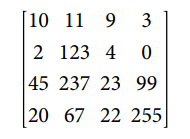


**filter (convolutional kernel)** is matrix  that *drag across our image* (multiply each element in the matrix by its corresponding member in channel of image)  
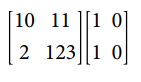


The result is $(10*1) + (11*0) + (2*1) + (123*0)=12$. After that we move our filter accros by `stride` size  
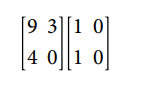



The final result (of applying our filter in all possible positions) called **feature map**.


Summary:  
- `in_channels` is the number of input channels (channels of image)  
- `out_channels` is the number of output channels (also it is the number of filters in current layer)  
- `kernel_size` is describes the height and width of our filter (may be square, may be not)  
- `stride` indicated how many steps across the input we move when we adjust the filter to a new position  
- `padding` comes in when we want to manupulate with size of input (e.g. padding equal to 1):  
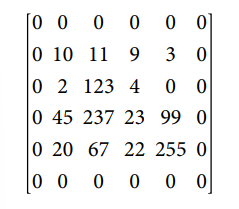

### Pooling
These layers reduce the resolution of the network from the previous input layer, which gives us fewer parameter in lower layers  

Lets look at the example:  
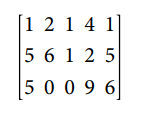


Now we want to use `MaxPool2D` with *kernel_size=3* and *stride=2*. We get these tensors:  
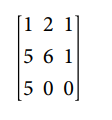
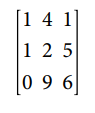


In `MaxPool` we take the maximum from each of these tensors
*Also, PyTorch provides `AdaptiveMaxPool`, which work independently of incoming tensor's dimensions



### Dropout
Issue with neural networks is their **tendency to overfit to training data**. The `Dropout` layer means that *we just don't train a random bunch of nodes within the network during a training cycle*. In other words: each training cycle will ignore a different selection of the input. It **should help generalization even futher**.

By default: `p`=0.5 (means that 50% of inputs is randomly zeroed out)

# Solution
Now lets train our CNN and evaluate it

### Data preparing

In [7]:
transformations = transforms.Compose([
    
    # it is standard size which let GPU work faster
    transforms.Resize((64, 64)),
    
    # the default transform
    transforms.ToTensor(),
    
    # normalization is important to prevent
    # the values from getting too large
    # (exploding gradient problem)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# this values for mean and std are statistics from ImageNet
# (often use for other datasets)


# little function that check our image
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

train_root = './train/'
train_dataset = ImageFolder(root=train_root,
                            transform=transformations,
                            is_valid_file=check_image)

val_root = './val/'
val_dataset = ImageFolder(root=val_root,
                          transform=transformations,
                          is_valid_file=check_image)

test_root = './test/'
test_dataset = ImageFolder(root=test_root,
                           transform=transformations,
                           is_valid_file=check_image)


BATCH = 4

train_data = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=BATCH,
                                        shuffle=True)
val_data = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=BATCH,
                                        shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=BATCH,
                                        shuffle=True)

### Model, loss, criterion + hyperparameters of our training cycle

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(alexnet.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
alexnet = alexnet.to(device) # copy model to the GPU   

### needed functions

In [18]:
def train_cycle(model,
                optimizer,
                loss_function,
                train_loader,
                val_loader,
                number_of_epoches=15,
                device='cpu'):
    
    for epoch in range(number_of_epoches):
            training_loss = 0.0
            valid_loss = 0.0
            
            model.train()
            for batch in train_loader:
                # reset grad to zero
                optimizer.zero_grad()
                
                # got the data
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # forward pass
                output = model(inputs)
                
                # calculate the loss
                loss = loss_function(output, targets)
        
                # calculate the gradients
                loss.backward()
            
                # update our weights
                optimizer.step()
                
                training_loss += loss.data.item() * inputs.size(0)
            training_loss /= len(train_loader.dataset)
            
            # to evaluation mode
            model.eval()
            number_of_correct = 0
            number_of_examples = 0
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                loss = loss_function(output, targets)
                valid_loss += loss.data.item() * inputs.size(0)
                # dim=1 in softmax because dim=0 respond to batch size
                correct_mask = torch.eq(torch.max(F.softmax(output, dim=1),
                                                  dim=1)[1], targets)
                number_of_correct += torch.sum(correct_mask).item()
                number_of_examples += correct_mask.shape[0]
            valid_loss /= len(val_loader.dataset)
            accuracy = number_of_correct / number_of_examples
            
            print('Epoch №{}:\n -- Training loss = {:.5f}\n -- Validation loss = {:.5f}\n -- Accuracy = {:.5f}'.format(epoch+1, training_loss, valid_loss, accuracy)) 


def make_prediction(model, img_path):
    labels = ['cat', 'fish']
    
    img = Image.open(img_path)
    display(img)
    # reuse the transformation pipeline we made earlier
    img = transformations(img)
    img = img.to(device)
    # our network uses batches, so we should add a new dimension at the front
    img = img.unsqueeze(0)
    
    model.eval()
    prediction = F.softmax(model(img), dim=1)
    prediction = labels[prediction.argmax()]
    # argmax return the index of the highest value of the tensor,
    # which
    print(f'\nIt is <{prediction}>')
  

def test_accuracy(model, test_loader):
    model.eval()
    num_correct = 0
    num_examples = len(test_loader.dataset)
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        
        correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
        num_correct += torch.sum(correct).item()

    print('Accuracy on test: {:.3f}'.format(num_correct / num_examples))

### Training

In [11]:
train_cycle(model=alexnet,
           loss_function=loss_fn,
           optimizer=optimizer,
           train_loader=train_data,
           val_loader=val_data,
           number_of_epoches=10,
           device='cuda')

Epoch №1:
 -- Training loss = 0.71567
 -- Validation loss = 0.67183
 -- Accuracy = 0.87879
Epoch №2:
 -- Training loss = 0.69416
 -- Validation loss = 0.65526
 -- Accuracy = 0.87879
Epoch №3:
 -- Training loss = 0.69301
 -- Validation loss = 0.69087
 -- Accuracy = 0.87879
Epoch №4:
 -- Training loss = 0.69348
 -- Validation loss = 0.66915
 -- Accuracy = 0.87879
Epoch №5:
 -- Training loss = 0.69303
 -- Validation loss = 0.66586
 -- Accuracy = 0.87879
Epoch №6:
 -- Training loss = 0.69278
 -- Validation loss = 0.66472
 -- Accuracy = 0.87879
Epoch №7:
 -- Training loss = 0.69248
 -- Validation loss = 0.66394
 -- Accuracy = 0.87879
Epoch №8:
 -- Training loss = 0.69246
 -- Validation loss = 0.66063
 -- Accuracy = 0.87879
Epoch №9:
 -- Training loss = 0.69247
 -- Validation loss = 0.66333
 -- Accuracy = 0.87879
Epoch №10:
 -- Training loss = 0.69273
 -- Validation loss = 0.66142
 -- Accuracy = 0.87879


### Evaluate

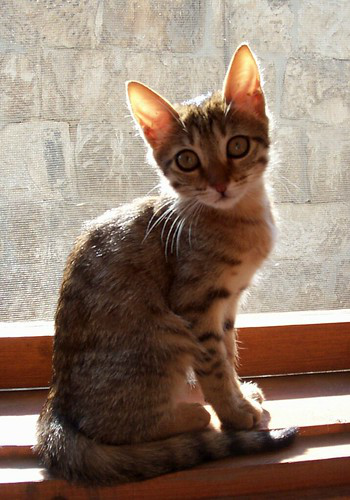

It is <cat>


In [ ]:
make_prediction(alexnet, './val/cat/54453125_ac74c8ba1d.jpg')

In [ ]:
test_accuracy(alexnet, test_data)

Accuracy on test: 0.825


# What about pretrained models ?
Define model each time you want could be a chore, so PyTorch provides many of the most popular models by default in `torchvision` library

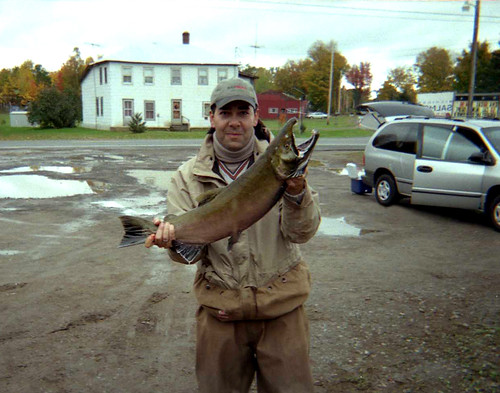


it is coho


In [25]:
from torchvision.models import resnet34, ResNet34_Weights
import random
from torchvision import io

w = ResNet34_Weights.DEFAULT
model = resnet34(weights=w)
preprocess = w.transforms()


fish = './test/fish/' + random.choice(os.listdir('./test/fish/'))
model.eval()
img = Image.open(fish)
display(img)
batch = preprocess(img).unsqueeze(0)
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
category_name = w.meta['categories'][class_id]
print(f'\nit is {category_name}')